# MHKiT Power Module  
The following runs through an example of the MHKiT Power Module to compute power, instantaneous frequency, and harmonics from time series of voltage and current. 



In [1]:
import numpy as np
import pandas as pd
from mhkit import power, utils

data = pd.read_csv('data/2020224_181521_PowRaw.csv',skip_blank_lines=True,index_col='Time_UTC') #reading in timeseries data of voltage and current
data.index=pd.to_datetime(data.index)
data

,MODAQ_Va_V,MODAQ_Vb_V,MODAQ_Vc_V,MODAQ_Ia_I,MODAQ_Ib_I,MODAQ_Ic_I
Time_UTC,,,,,,
2020-02-24 18:15:21.499998208,10652.764496,-8499.446320,-1850.166138,-23.213654,19.219666,4.023438
2020-02-24 18:15:21.500018208,10691.122620,-8428.702576,-1927.626526,-23.404846,19.181671,4.289856
2020-02-24 18:15:21.500038209,10732.961151,-8364.997162,-2001.269318,-23.493042,19.033966,4.478912
2020-02-24 18:15:21.500058210,10775.892639,-8304.582245,-2071.241791,-23.680115,18.917847,4.858246
2020-02-24 18:15:21.500078210,10818.297028,-8248.074066,-2138.016785,-23.737946,18.702087,5.092468
...,...,...,...,...,...,...
2020-02-24 18:15:21.659899962,-11156.280273,3761.971924,7052.360229,24.501648,-8.213348,-16.351318
2020-02-24 18:15:21.659919962,-11136.750458,3657.195374,7126.638641,24.455872,-8.047028,-16.470337
2020-02-24 18:15:21.659939962,-11115.166504,3550.678619,7200.568237,24.535980,-7.887268,-16.733246


## Compute Power Characteristics 
The MHKiT power.characteristics module can be used to compute quantities of interest from voltage and current time series. 


In [2]:
# First we need to seperate the voltage and current timeseries into seperate dataFrames
power_factor = 0.96 #set the power factor for the system
voltage = data[['MODAQ_Va_V', 'MODAQ_Vb_V', 'MODAQ_Vc_V']]
print(type(voltage.index[5]))
current = data[['MODAQ_Ia_I','MODAQ_Ib_I','MODAQ_Ic_I']]
ac_power = power.characteristics.ac_power_three_phase(voltage,current,power_factor) #compute the instantaneous AC power in W


<class 'pandas._libs.tslibs.timestamps.Timestamp'>


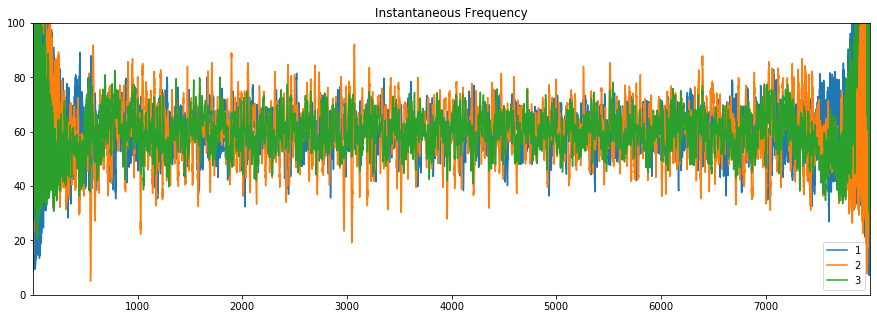

In [3]:
# Next we can compute the instantaneous frequency of the voltage time series 
inst_freq = power.characteristics.instantaneous_frequency(voltage) #compute the instantaneous frequency
inst_freq.plot(figsize=(15,5), ylim=(0,100),title='Instantaneous Frequency')

## Calculate Harmonics
Next, the power.quality module can be used to compute harmonics of current and current distortions. 

,0,1,2
0.00,672.189789,5640.251007,5560.604553
6.25,713.085606,5380.573801,5705.269128
12.50,1421.737324,5641.448646,5936.044023
18.75,2217.312340,6030.068606,6322.931620
25.00,3205.658723,6678.046407,6948.925512
...,...,...,...
2968.75,135.661239,75.401476,62.617815
2975.00,127.258508,62.684440,63.961111
2981.25,133.795240,70.842087,58.477475
2987.50,129.635052,71.590734,63.695472


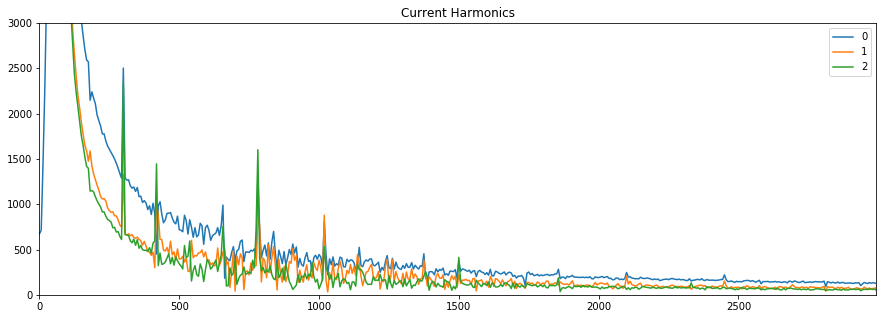

In [8]:
sample_freq = 50000 #Hz setting the nominal sampling frequency
grid_freq = 60 #Hz setting the frequency of the grid the device would be conected to
rated_current = 18.8 #Amps
harmonics = power.quality.harmonics(current,sample_freq)
harmonics.plot(figsize=(15,5),ylim=(0,3000),title='Current Harmonics')
harmonics

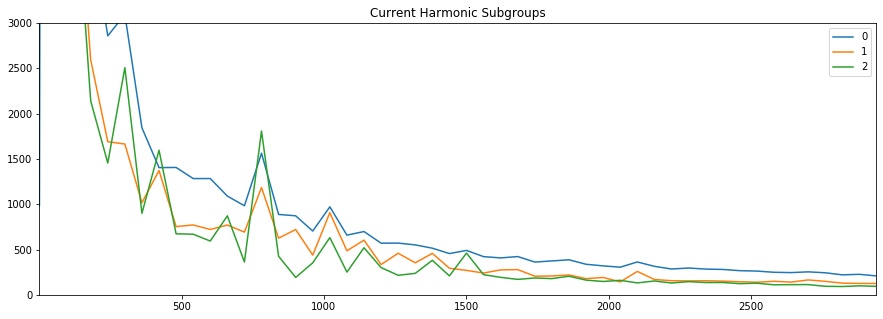

In [9]:
h_s=power.quality.harmonic_subgroups(harmonics,grid_freq) #computing the harmonic subgroups based on IEC TS 62600-30
h_s.plot(figsize=(15,5),ylim=(0,3000),title='Current Harmonic Subgroups')

In [10]:
#Finally we can compute the total harmonic current distortion as a percentage 
THCD=power.quality.total_harmonic_current_distortion(h_s,rated_current) #Compute the THCD from harmonic subgroups and rated current for the device
print('THCD =',THCD)

THCD = 0    11.306395
1     7.617092
2     7.424798
dtype: float64
